In [1]:
# Source: http://learnandshare645.blogspot.hk/2016/06/3d-cnn-in-keras-action-recognition.html
import georaster
import skimage
from skimage import io
from sklearn.utils import class_weight

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import ZeroPadding3D, Conv3D, MaxPooling3D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard

from keras.optimizers import SGD, RMSprop, adam
from keras.utils import np_utils, generic_utils

import tensorflow as tf
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn import *
from sklearn.model_selection import train_test_split #cross
#from sklearn import cross_validation #Deprecated???
from sklearn import preprocessing

Using TensorFlow backend.


Label_tifs/Mask_liblikielised30_80.tif
1
Label_tifs/Mask_rohttaimed.tif
2
Label_tifs/Mask_suvinisu.tif
3
Label_tifs/Mask_suvioder.tif
4
Label_tifs/Mask_suviraps.tif
5
Label_tifs/Mask_talinisu.tif
6


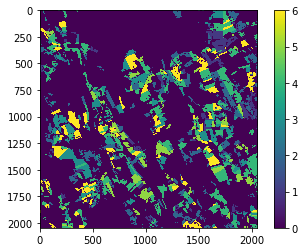

In [7]:
#Koond label maski tegemine.
# 0 - muu
# 1 - liblikielised
# 2 - rohttaimed
# 3 - suvinisu
# 4 - suvioder
# 5 - suviraps
# 6 - talinisu

labels = np.zeros((2048,2048))

listing = os.listdir('./Label_tifs')
listing.sort()
i=1
for filename in listing:
    path = 'Label_tifs/'+filename
    #if(i==6):
    #    break
    print(path)
    im = georaster.SingleBandRaster(path)
    mask = im.r!=0.0
    mask = mask.astype(int)*i
    print(i)
    labels += mask
    i+=1

f, arr = plt.subplots()
img = arr.imshow(labels,vmin=0,vmax=6)
cig = f.colorbar(img)
plt.show()

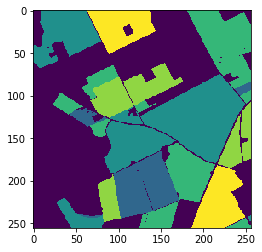

In [8]:
#f, axarr = plt.subplots(4,4)
label_tulemus = skimage.util.view_as_windows(labels,(256,256),256)
for i in range(8):
    for j in range(8):
        if (i==2 and j==3):
            #axarr[i-2][j].imshow(label_tulemus[i][j])
            plt.imshow(label_tulemus[i][j])

In [9]:
# image specification
img_rows,img_cols = 8,8
nb_images = 5    # S-2 piltide arv
nb_bands = 22  # Bandide arv
nb_samples = 256*256


# Training data

X_tr = np.zeros((nb_samples, nb_bands, img_rows, img_cols, nb_images))           # variable to store entire dataset

In [10]:
listing = os.listdir('Data')
listing.sort()
print(listing)

#f, axarr = plt.subplots(2,2)
j=0
for file in listing:
    Temp_array = []
    im = georaster.MultiBandRaster('Data/'+file, bands="all")
    for i in range(nb_bands):
        tulemus = skimage.util.view_as_windows(im.r[:,:,i],(256,256),256)
        #plt.imshow(tulemus[4][0])
        #plt.imshow(im.r[:, :, i],vmin=np.percentile(im.r[:,:,i],0.1),vmax=np.percentile(im.r[:,:,i],99.5))
        padded_overpad = skimage.util.pad(tulemus[2][3],4,'reflect')
        padded = padded_overpad[:-1,:-1]
        windows = skimage.util.view_as_windows(padded,(8,8)).astype('float32')
        #print(padded.shape)
        #print(windows.shape)
        reshaped_windows = np.reshape(windows,(256*256,8,8))
        #print(reshaped_windows.shape)
        #plt.imshow(windows[8,8,2:4,2:4],cmap="flag")
        X_tr[:,i,:,:,j] = reshaped_windows
        #print(windows[8,8,2:4,2:4])
        #plt.imshow(reshape_test[0],cmap="flag")
        #plt.imshow(windows_overpad[0][0])
        #axarr[0][0].imshow(padded[4:12,4:12])
        #axarr[0][1].imshow(tulemus[4][0][0:8,0:8])
    j+=1

['20180510.tif', '20180515.tif', '20180520.tif', '20180525.tif', '20180530.tif']


/home/rus/anaconda3/envs/thesis/lib/python3.6/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "


In [12]:
print(X_tr.shape)
print(X_tr[8*128+8][0][2:4,2:4,0])

(65536, 22, 8, 8, 5)
[[-0.09883404 -0.09727489]
 [-0.08134014 -0.06784489]]


In [8]:
# Assign Label to each class
label=np.zeros((nb_samples,),dtype = int)
for i in range(256):
    for j in range(256):
        label[i*256+j] = label_tulemus[2][3][i][j]

train_data = [X_tr,label]

(X_train, y_train) = (train_data[0],train_data[1])
print('X_train shape:', X_train.shape)
print('Y_train length:', len(y_train))

print(np.unique(y_train))

X_train shape: (65536, 22, 8, 8, 5)
Y_train length: 65536
[0 2 3 4 5 6]


In [12]:
# CNN Training parameters

batch_size = 128
nb_classes = 7 # NB! Tegelt peaks olema 7 :D Lihtsalt 128x128 tile ei sisalda kõiki klasse
nb_epoch = 10

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)


# number of convolutional filters to use at each layer
nb_filters = [  32,   # 1st conv layer
                32,    # 2nd conv
                64    # 3rd conv
             ]

# level of pooling to perform at each layer (POOL x POOL)
nb_pool = [2,2,1]

# level of convolution to perform at each layer (CONV x CONV)
nb_conv = [3,3]

# set weights for unbalanced classes
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

# Pre-processing
train_set = X_tr.astype('float32')
#Vaja teha iga bandi jaoks eraldi. Lisaks on vaja arvestada peegeldustega /
# / percentile valida suhteliselt käsitsi, ehk teha normaalne funktsioon, mis selle mõistlikult määrab
#train_set -= np.mean(train_set) 
#train_set /= np.max(train_set)

In [10]:
print(class_weights)

[0.38483582 3.39705577 2.13312502 0.50601479 1.09079409 2.19257277
 3.45726947]


In [11]:
# Define model
model_exists = os.path.exists('current.h5')
if (model_exists):
    model = load_model('current.h5')
    print("**************************************************")
    print("current.h5 model loaded")

else:
    model = Sequential()

    print(nb_filters[0], 'filters')
    print('input shape', img_rows, 'rows', img_cols, 'cols', nb_images, 'patchsize')

    #1st conv
    model.add(Conv3D(
        nb_filters[0],
        (3, # depth
        3, # rows
        3), # cols
        activation="relu",
        padding = "same",
        data_format = 'channels_first',
        input_shape=(nb_bands, img_rows, img_cols, nb_images)
    ))
    
    model.add(BatchNormalization())

    #1st pool
    model.add(MaxPooling3D(pool_size=(nb_pool[0], nb_pool[1], nb_pool[2]), data_format='channels_first'))
    
    #2nd conv
    model.add(Conv3D(
        nb_filters[1],
        (3, # depth
        3, # rows
        3), # cols
        activation="relu",
        padding = "same",
        data_format = 'channels_first',
        input_shape=(nb_bands, img_rows, img_cols, nb_images)
    ))
    
    model.add(BatchNormalization())

    #2nd pool
    model.add(MaxPooling3D(pool_size=(nb_pool[0], nb_pool[1], nb_pool[2]), data_format= 'channels_first'))
    
    #3rd conv
    model.add(Conv3D(
        nb_filters[2],
        (3, # depth
        3, # rows
        3), # cols
        activation="relu",
        padding = "same",
        data_format = 'channels_first',
        input_shape=(nb_bands, img_rows, img_cols, nb_images)
    ))
    
    model.add(BatchNormalization())

    #3rd pool
    model.add(MaxPooling3D(pool_size=(nb_pool[0], nb_pool[1], nb_pool[2]), data_format= 'channels_first'))
    
    model.add(Flatten())

    model.add(Dense(64, activation='relu', kernel_initializer='normal'))

    model.add(Dropout(0.5))

    model.add(Dense(nb_classes,kernel_initializer='normal'))

    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.00005), metrics=['mse', 'accuracy'])


32 filters
input shape 8 rows 8 cols 5 patchsize


In [13]:
# Callbacks
es = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=0,
                              verbose=0, mode='auto')
cb_list = [es]

In [13]:
# Split the data
X_train_new, X_val_new, y_train_new,y_val_new = train_test_split(train_set, Y_train, test_size=0.2, random_state=4)
#X_train_new, X_val_new = X_tr[:13107,:,:,:,:], X_tr[13107:,:,:,:,:]
#Y_train_new, Y_val_new = Y_train[:13107,:], Y_train[13107:,:]

print(X_train_new.shape)
print(X_val_new.shape)
print(y_train_new.shape)
print(y_val_new.shape)

print(X_train_new)

#print(np.unique(y_train,return_counts=True))
#print(9412/(9412+2046+597+1440+2889))
#
#print(np.unique(y_train_new,return_counts=True))
#print(52428/(52428+13107))
#print(np.unique(y_val_new,return_counts=True))
#print(13108/(13108+3277))

(52428, 22, 8, 8, 5)
(13108, 22, 8, 8, 5)
(52428, 7)
(13108, 7)
[[[[[-4.91430722e-02 -3.47929411e-02 -1.27832750e-02 -3.91002791e-03
      2.40517990e-03]
    [-3.84376310e-02 -2.96830423e-02 -5.03428793e-03  6.73276512e-03
      3.20800464e-03]
    [-3.29568237e-02  3.53301107e-03  2.32358798e-02  3.17197330e-02
      1.92535743e-02]
    ...
    [-7.32603297e-02 -3.65358777e-02 -1.82442255e-02 -8.78525618e-03
     -7.30582559e-03]
    [-6.17646649e-02 -6.67982623e-02 -3.69033888e-02 -3.72081585e-02
     -4.84740511e-02]
    [-5.86941727e-02 -5.86225130e-02 -5.92805520e-02 -3.87986861e-02
     -2.90396120e-02]]

   [[-5.12431711e-02 -3.93830761e-02 -1.47407958e-02 -1.16200354e-02
     -8.03344417e-03]
    [-3.65828983e-02 -2.81205866e-02 -8.16556625e-03  9.10298526e-03
      9.14239790e-03]
    [-2.51088347e-02  4.55063675e-03  2.51188818e-02  3.67015116e-02
      2.69047227e-02]
    ...
    [-5.42674102e-02 -2.02140473e-02  7.56519893e-03  8.74949247e-03
     -8.28984077e-04]
    [-4.

In [15]:
# Train the model
hist = model.fit(
    X_train_new,
    y_train_new,
    validation_data=(X_val_new,y_val_new),
    batch_size=batch_size,
    epochs = nb_epoch,
    class_weight=class_weights,
    callbacks=cb_list,
    )

Train on 52428 samples, validate on 13108 samples
Epoch 1/10
52428/52428 [==============================] - 285s 5ms/step - loss: 0.8614 - mean_squared_error: 0.0595 - acc: 0.7191 - val_loss: 0.4899 - val_mean_squared_error: 0.0349 - val_acc: 0.8334
Epoch 2/10
52428/52428 [==============================] - 280s 5ms/step - loss: 0.4551 - mean_squared_error: 0.0330 - acc: 0.8469 - val_loss: 0.3117 - val_mean_squared_error: 0.0231 - val_acc: 0.8967
Epoch 3/10
52428/52428 [==============================] - 279s 5ms/step - loss: 0.3351 - mean_squared_error: 0.0245 - acc: 0.8886 - val_loss: 0.2230 - val_mean_squared_error: 0.0162 - val_acc: 0.9250
Epoch 4/10
52428/52428 [==============================] - 279s 5ms/step - loss: 0.2629 - mean_squared_error: 0.0193 - acc: 0.9110 - val_loss: 0.1815 - val_mean_squared_error: 0.0132 - val_acc: 0.9395
Epoch 5/10
52428/52428 [==============================] - 280s 5ms/step - loss: 0.2210 - mean_squared_error: 0.0160 - acc: 0.9282 - val_loss: 0.1720 -

In [ ]:
# Save model
#model.save("current.h5")


In [2]:
# Load model
from keras.models import load_model
loaded_model = load_model("current.h5")


Using TensorFlow backend.


In [26]:

# serialize model to JSON
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("model.h5")
#print("Saved model to disk")
 
# later...
 
# load json and create model
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")

In [14]:
 # Evaluate the model
score = loaded_model.evaluate(
    X_val_new,
    y_val_new,
    batch_size=batch_size,
    #show_accuracy=True
    )
print('**********************************************')
print('Test score:', score)


13108/13108 [==============================] - 14s 1ms/step
**********************************************
Test score: [1.866545561504393, 0.08726991230589536, 0.6397619775093144]


In [65]:

#hist = model.fit(train_set, Y_train, batch_size=batch_size,
#         nb_epoch=nb_epoch,validation_split=0.2, show_accuracy=True,
#           shuffle=True)


print('History', hist.history)

# Plot the results
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
mse=hist.history['mean_squared_error']
xc=range(8)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

TypeError: evaluate() got an unexpected keyword argument 'show_accuracy'

In [9]:
y_prob = loaded_model.predict(X_tr) 
y_classes = y_prob.argmax(axis=-1)

In [10]:
print(y_prob.min())
print(np.unique(y_classes))

1.04793785e-13
[0 1 2 3 4 5 6]


Accuracy is:
0.6358642578125


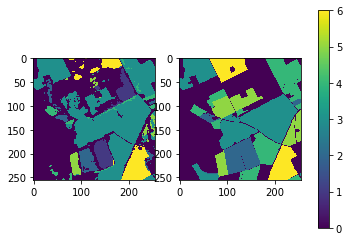

In [15]:
prediction_map = np.zeros((256,256))
count=0
for i in range(256):
    for j in range(256):
            prediction_map[i][j] = y_classes[256*i+j]
            if prediction_map[i][j]==label_tulemus[2][3][i][j]:
                count+=1
#plt.imshow(prediction_map)

print("Accuracy is:")
print(count/(256*256))

f, arr = plt.subplots(1,2)
im = arr[0].imshow(prediction_map)
im = arr[1].imshow(label_tulemus[2][3])
f.colorbar(im, ax=arr.ravel().tolist())

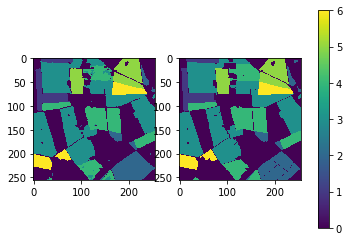

In [18]:
#Training_val set at 95% accuracy
prediction_map = np.zeros((256,256))
for i in range(256):
    for j in range(256):
            prediction_map[i][j] = y_classes[256*i+j]
#plt.imshow(prediction_map)

f, arr = plt.subplots(1,2)
im = arr[0].imshow(prediction_map)
im = arr[1].imshow(label_tulemus[4][6])
f.colorbar(im, ax=arr.ravel().tolist())

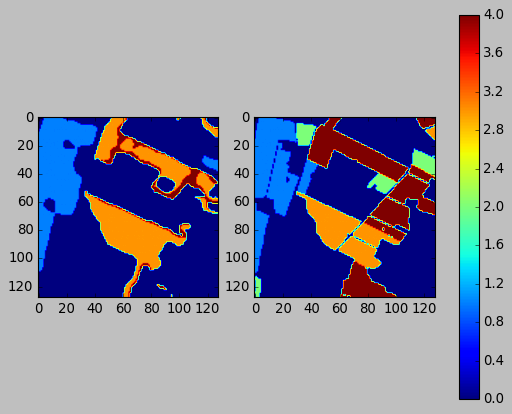

In [73]:
prediction_map = np.zeros((128,128))
for i in range(128):
    for j in range(128):
            prediction_map[i][j] = y_classes[128*i+j]
#plt.imshow(prediction_map)

f, arr = plt.subplots(1,2)
im = arr[0].imshow(prediction_map)
im = arr[1].imshow(label_tulemus[4][0])
f.colorbar(im, ax=arr.ravel().tolist())

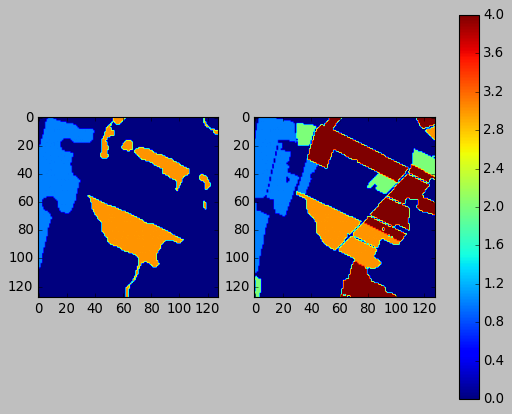

In [97]:
prediction_map = np.zeros((128,128))
for i in range(128):
    for j in range(128):
            prediction_map[i][j] = y_classes[128*i+j]
#plt.imshow(prediction_map)

f, arr = plt.subplots(1,2)
im = arr[0].imshow(prediction_map)
im = arr[1].imshow(label_tulemus[4][0])
f.colorbar(im, ax=arr.ravel().tolist())